## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = 1000

In [6]:
DOMAIN = 'eclipse'
METHOD = 'baseline_dwen_{}'.format(epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [7]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
import keras.backend as K

MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D

(20, 20)

In [9]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 7,
 'bug_status': 3,
 'component': 927,
 'priority': 5,
 'product': 189,
 'version': 551}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


361006

#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 35.3 s, sys: 3.23 s, total: 38.5 s
Wall time: 38.2 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 1.73 s, sys: 13.8 ms, total: 1.74 s
Wall time: 1.73 s


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 145 ms, sys: 105 µs, total: 145 ms
Wall time: 144 ms


In [18]:
len(bug_train_ids)

1546362

In [19]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path='test_chronological')

Reading test data for classification
CPU times: user 101 ms, sys: 210 µs, total: 101 ms
Wall time: 99.3 ms


In [20]:
len(baseline.test_data)

43399

## Siamese  model

In [21]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [22]:
from keras.layers import concatenate, Dropout, Add

bug_t_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
    
title_embed = similarity_model.get_layer('embedding_layer_title')
desc_embed = similarity_model.get_layer('embedding_layer_desc')
title_encoder = similarity_model.get_layer('global_average_pooling1d_1')
desc_encoder = similarity_model.get_layer('global_average_pooling1d_2')

# Bug A
bug_t_a_embed = title_embed(bug_t_a_input)
bug_d_a_embed = desc_embed(bug_d_a_input)
# Bug B
bug_t_b_embed = title_embed(bug_t_b_input)
bug_d_b_embed = desc_embed(bug_d_b_input)

# Bug A
bug_t_a = title_encoder(bug_t_a_embed)
bug_d_a = desc_encoder(bug_d_a_embed)
# Bug B
bug_t_b = title_encoder(bug_t_b_embed)
bug_d_b = desc_encoder(bug_d_b_embed)

model = similarity_model.get_layer('merge_features_dwen_a')

bug_a = model([bug_t_a, bug_d_a])
bug_b = model([bug_t_b, bug_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    # x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_input, bug_t_b_input, bug_d_a_input, bug_d_b_input], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 20)           0                                            
________________________________________________________________________________________________

In [23]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [24]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [25]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [26]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [27]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/100
10/10 [==============================] - 5s 542ms/step - loss: 0.7167 - acc: 0.5122 - val_loss: 0.6752 - val_acc: 0.6016
Epoch 2/100
10/10 [==============================] - 5s 500ms/step - loss: 0.6853 - acc: 0.5588 - val_loss: 0.6560 - val_acc: 0.6230
Epoch 3/100
10/10 [==============================] - 5s 517ms/step - loss: 0.6598 - acc: 0.6090 - val_loss: 0.6398 - val_acc: 0.6445
Epoch 4/100
10/10 [==============================] - 5s 502ms/step - loss: 0.6437 - acc: 0.6283 - val_loss: 0.6219 - val_acc: 0.6621
Epoch 5/100
10/10 [==============================] - 5s 513ms/step - loss: 0.6217 - acc: 0.6566 - val_loss: 0.6057 - val_acc: 0.6738
Epoch 6/100
10/10 [==============================] - 5s 505ms/step - loss: 0.6108 - acc: 0.6682 - val_loss: 0.5968 - val_acc: 0.6836
Epoch 7/100
10/10 [==============================] - 5s 507ms/step - loss: 0.6044 - acc: 0.6740 - val_loss: 0.5840 - val_acc: 0.6992
Epoch 8/100
10/10 [==============================] - 5s 503ms/step 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107760). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 504ms/step - loss: 0.5783 - acc: 0.7027 - val_loss: 0.5534 - val_acc: 0.6855
Epoch 25/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5636 - acc: 0.7099 - val_loss: 0.5497 - val_acc: 0.6875
Epoch 26/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.5616 - acc: 0.6963

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107519). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 500ms/step - loss: 0.5658 - acc: 0.7066 - val_loss: 0.5510 - val_acc: 0.6797
Epoch 27/100
10/10 [==============================] - 5s 510ms/step - loss: 0.5693 - acc: 0.7029 - val_loss: 0.5470 - val_acc: 0.6973
Epoch 28/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5622 - acc: 0.7115 - val_loss: 0.5452 - val_acc: 0.6992
Epoch 29/100
10/10 [==============================] - 5s 503ms/step - loss: 0.5583 - acc: 0.7162 - val_loss: 0.5429 - val_acc: 0.6992
Epoch 30/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5513 - acc: 0.7199 - val_loss: 0.5505 - val_acc: 0.7012
Epoch 31/100
10/10 [==============================] - 5s 516ms/step - loss: 0.5619 - acc: 0.7104 - val_loss: 0.5455 - val_acc: 0.7090
Epoch 32/100
10/10 [==============================] - 5s 510ms/step - loss: 0.5684 - acc: 0.7063 - val_loss: 0.5465 - val_acc: 0.7051
Epoch 33/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.557

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119199). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5501 - acc: 0.7236

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123951). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 506ms/step - loss: 0.5613 - acc: 0.7140 - val_loss: 0.5454 - val_acc: 0.7051
Epoch 34/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.5602 - acc: 0.7168

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113341). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5512 - acc: 0.7134

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115840). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 507ms/step - loss: 0.5615 - acc: 0.7103 - val_loss: 0.5460 - val_acc: 0.7070
Epoch 35/100
10/10 [==============================] - 5s 509ms/step - loss: 0.5556 - acc: 0.7188 - val_loss: 0.5448 - val_acc: 0.7051
Epoch 36/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5568 - acc: 0.7154 - val_loss: 0.5445 - val_acc: 0.7129
Epoch 37/100
10/10 [==============================] - 5s 507ms/step - loss: 0.5557 - acc: 0.7189 - val_loss: 0.5426 - val_acc: 0.7148
Epoch 38/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5591 - acc: 0.7136 - val_loss: 0.5398 - val_acc: 0.7148
Epoch 39/100
 3/10 [========>.....................] - ETA: 3s - loss: 0.5577 - acc: 0.7197

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107902). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 2s - loss: 0.5578 - acc: 0.7192

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115382). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 508ms/step - loss: 0.5533 - acc: 0.7209 - val_loss: 0.5411 - val_acc: 0.7090
Epoch 40/100
10/10 [==============================] - 5s 505ms/step - loss: 0.5576 - acc: 0.7104 - val_loss: 0.5399 - val_acc: 0.7109
Epoch 41/100
10/10 [==============================] - 5s 496ms/step - loss: 0.5603 - acc: 0.7162 - val_loss: 0.5425 - val_acc: 0.7148
Epoch 42/100
 1/10 [==>...........................] - ETA: 2s - loss: 0.5862 - acc: 0.6953

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107988). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5704 - acc: 0.7139

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112749). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 502ms/step - loss: 0.5635 - acc: 0.7115 - val_loss: 0.5413 - val_acc: 0.7070
Epoch 43/100
10/10 [==============================] - 5s 508ms/step - loss: 0.5547 - acc: 0.7164 - val_loss: 0.5425 - val_acc: 0.7012
Epoch 44/100
10/10 [==============================] - 5s 512ms/step - loss: 0.5609 - acc: 0.7109 - val_loss: 0.5426 - val_acc: 0.7051
Epoch 45/100
10/10 [==============================] - 5s 509ms/step - loss: 0.5533 - acc: 0.7170 - val_loss: 0.5429 - val_acc: 0.7070
Epoch 46/100
10/10 [==============================] - 5s 514ms/step - loss: 0.5528 - acc: 0.7169 - val_loss: 0.5401 - val_acc: 0.7109
Epoch 47/100
10/10 [==============================] - 5s 506ms/step - loss: 0.5452 - acc: 0.7312 - val_loss: 0.5389 - val_acc: 0.6992
Epoch 48/100
10/10 [==============================] - 5s 504ms/step - loss: 0.5473 - acc: 0.7214 - val_loss: 0.5462 - val_acc: 0.6934
Epoch 49/100
10/10 [==============================] - 5s 509ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113187). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5600 - acc: 0.7124

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105643). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 509ms/step - loss: 0.5550 - acc: 0.7166 - val_loss: 0.5426 - val_acc: 0.7090
Epoch 54/100
10/10 [==============================] - 5s 503ms/step - loss: 0.5547 - acc: 0.7191 - val_loss: 0.5401 - val_acc: 0.7168
Epoch 55/100
10/10 [==============================] - 5s 491ms/step - loss: 0.5480 - acc: 0.7228 - val_loss: 0.5400 - val_acc: 0.7070
Epoch 56/100
10/10 [==============================] - 5s 519ms/step - loss: 0.5447 - acc: 0.7239 - val_loss: 0.5404 - val_acc: 0.7109
Epoch 57/100
10/10 [==============================] - 5s 511ms/step - loss: 0.5602 - acc: 0.7151 - val_loss: 0.5395 - val_acc: 0.7070
Epoch 58/100
10/10 [==============================] - 5s 501ms/step - loss: 0.5591 - acc: 0.7179 - val_loss: 0.5390 - val_acc: 0.7129
Epoch 59/100
10/10 [==============================] - 5s 508ms/step - loss: 0.5610 - acc: 0.7130 - val_loss: 0.5399 - val_acc: 0.7031
Epoch 60/100
10/10 [==============================] - 5s 506ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118518). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 506ms/step - loss: 0.5510 - acc: 0.7246 - val_loss: 0.5370 - val_acc: 0.7246
Epoch 62/100
10/10 [==============================] - 5s 510ms/step - loss: 0.5534 - acc: 0.7221 - val_loss: 0.5371 - val_acc: 0.7168
Epoch 63/100
10/10 [==============================] - 5s 504ms/step - loss: 0.5507 - acc: 0.7202 - val_loss: 0.5352 - val_acc: 0.7148
Epoch 64/100
10/10 [==============================] - 5s 493ms/step - loss: 0.5515 - acc: 0.7232 - val_loss: 0.5379 - val_acc: 0.7012
Epoch 65/100
10/10 [==============================] - 5s 510ms/step - loss: 0.5568 - acc: 0.7183 - val_loss: 0.5380 - val_acc: 0.7090
Epoch 66/100
10/10 [==============================] - 5s 511ms/step - loss: 0.5552 - acc: 0.7158 - val_loss: 0.5401 - val_acc: 0.7109
Epoch 67/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5505 - acc: 0.7208 - val_loss: 0.5392 - val_acc: 0.7129
Epoch 68/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.552

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118352). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 506ms/step - loss: 0.5579 - acc: 0.7163 - val_loss: 0.5388 - val_acc: 0.7109
Epoch 69/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5580 - acc: 0.7151 - val_loss: 0.5389 - val_acc: 0.7129
Epoch 70/100
10/10 [==============================] - 5s 504ms/step - loss: 0.5453 - acc: 0.7290 - val_loss: 0.5443 - val_acc: 0.7070
Epoch 71/100
 2/10 [=====>........................] - ETA: 3s - loss: 0.5534 - acc: 0.7163

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108412). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 507ms/step - loss: 0.5549 - acc: 0.7202 - val_loss: 0.5385 - val_acc: 0.7070
Epoch 72/100
10/10 [==============================] - 5s 504ms/step - loss: 0.5546 - acc: 0.7184 - val_loss: 0.5364 - val_acc: 0.7051
Epoch 73/100
10/10 [==============================] - 5s 510ms/step - loss: 0.5552 - acc: 0.7204 - val_loss: 0.5376 - val_acc: 0.7168
Epoch 74/100
10/10 [==============================] - 5s 506ms/step - loss: 0.5529 - acc: 0.7192 - val_loss: 0.5395 - val_acc: 0.7148
Epoch 75/100
10/10 [==============================] - 5s 500ms/step - loss: 0.5521 - acc: 0.7189 - val_loss: 0.5405 - val_acc: 0.7109
Epoch 76/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.5705 - acc: 0.7061

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118591). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 507ms/step - loss: 0.5481 - acc: 0.7192 - val_loss: 0.5375 - val_acc: 0.7285
Epoch 77/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5571 - acc: 0.7157 - val_loss: 0.5369 - val_acc: 0.7305
Epoch 78/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5521 - acc: 0.7203 - val_loss: 0.5391 - val_acc: 0.7207
Epoch 79/100
10/10 [==============================] - 5s 496ms/step - loss: 0.5533 - acc: 0.7166 - val_loss: 0.5385 - val_acc: 0.7227
Epoch 80/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.5581 - acc: 0.7148

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165164). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5572 - acc: 0.7178

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121271). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 505ms/step - loss: 0.5516 - acc: 0.7179 - val_loss: 0.5383 - val_acc: 0.7070
Epoch 81/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.5857 - acc: 0.6895

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113069). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5617 - acc: 0.7119

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100131). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 513ms/step - loss: 0.5465 - acc: 0.7259 - val_loss: 0.5404 - val_acc: 0.7090
Epoch 82/100
10/10 [==============================] - 5s 512ms/step - loss: 0.5509 - acc: 0.7224 - val_loss: 0.5397 - val_acc: 0.6934
Epoch 83/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5500 - acc: 0.7252 - val_loss: 0.5393 - val_acc: 0.7109
Epoch 84/100
10/10 [==============================] - 5s 509ms/step - loss: 0.5508 - acc: 0.7184 - val_loss: 0.5406 - val_acc: 0.7090
Epoch 85/100
10/10 [==============================] - 5s 505ms/step - loss: 0.5491 - acc: 0.7234 - val_loss: 0.5360 - val_acc: 0.7188
Epoch 86/100
10/10 [==============================] - 5s 507ms/step - loss: 0.5490 - acc: 0.7226 - val_loss: 0.5418 - val_acc: 0.6973
Epoch 87/100
10/10 [==============================] - 5s 512ms/step - loss: 0.5548 - acc: 0.7245 - val_loss: 0.5370 - val_acc: 0.7051
Epoch 88/100
10/10 [==============================] - 5s 501ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107647). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 3s - loss: 0.5735 - acc: 0.7012

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105493). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 3s - loss: 0.5644 - acc: 0.7057

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103339). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 5s 503ms/step - loss: 0.5450 - acc: 0.7200 - val_loss: 0.5414 - val_acc: 0.7246
Epoch 94/100
10/10 [==============================] - 5s 502ms/step - loss: 0.5546 - acc: 0.7215 - val_loss: 0.5377 - val_acc: 0.7285
Epoch 95/100
10/10 [==============================] - 5s 504ms/step - loss: 0.5596 - acc: 0.7151 - val_loss: 0.5407 - val_acc: 0.7168
Epoch 96/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5385 - acc: 0.7297 - val_loss: 0.5398 - val_acc: 0.7207
Epoch 97/100
10/10 [==============================] - 5s 509ms/step - loss: 0.5536 - acc: 0.7196 - val_loss: 0.5435 - val_acc: 0.7090
Epoch 98/100
10/10 [==============================] - 5s 508ms/step - loss: 0.5472 - acc: 0.7200 - val_loss: 0.5372 - val_acc: 0.7148
Epoch 99/100
10/10 [==============================] - 5s 500ms/step - loss: 0.5480 - acc: 0.7229 - val_loss: 0.5388 - val_acc: 0.7168
Epoch 100/100
10/10 [==============================] - 5s 507ms/step - loss

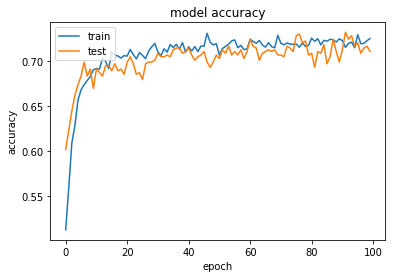

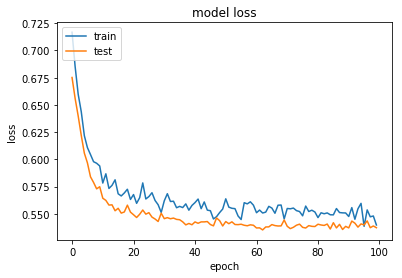

In [28]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [29]:
result = { }

In [30]:
number_of_pairs = len(baseline.test_data)

#### train

In [31]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, number_of_pairs, 1, 
                                                                             bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
acc_train

0.7220378819300428

#### test

In [32]:
from sklearn.metrics import accuracy_score

number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
acc_test

0.6684601027673449

### Roc AUC/SCORE

#### train

In [33]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_train = roc_auc_score(y_true, y_scores)
roc_train

0.8019617423127581

#### test

In [34]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_test = roc_auc_score(y_true, y_scores)
roc_test

0.7304059415443734

In [35]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

[1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,


In [36]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.66229637 0.33770363]
 [0.32537616 0.67462384]]


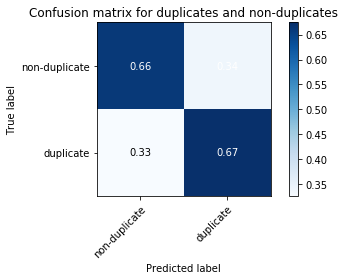

In [37]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")

Normalized confusion matrix
[[0.66229637 0.33770363]
 [0.32537616 0.67462384]]


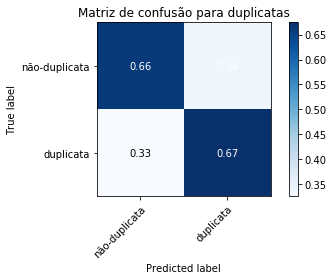

In [38]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")

#### Save the model

In [39]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [42]:
import _pickle as pickle

CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [43]:
result

{'acc_test': 0.6684601027673449,
 'acc_train': 0.7220378819300428,
 'method': 'baseline_dwen_1000',
 'roc_test': 0.7304059415443734,
 'roc_train': 0.8019617423127581}